# Zürich bike counter data

Contents:
- Read input files
- Remove non relevant columns
- Remove NaNs
- Translate column names to English
- Convert datetime strings to datetime objects
- Store data in feather format
- Explore the dataset, make visualizations

In [1]:
import os
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Pre-process the dataset

### Read input files

In [2]:
input_folder = '../data/zhbikes'

In [3]:
input_files = glob('{}/*.csv'.format(input_folder))

In [4]:
dataframes = [pd.read_csv(file)[['fk_zaehler','datum','velo_in','velo_out','fuss_in','fuss_out','objectid']] for file in input_files]

In [5]:
df = pd.concat(dataframes)

In [6]:
df.shape

(2610991, 7)

In [7]:
df.head()

,fk_zaehler,datum,velo_in,velo_out,fuss_in,fuss_out,objectid
0,Y2G14045587,2016-01-14T10:15:00,4.0,NaN,NaN,NaN,3600767
1,Y2G14045587,2016-01-14T10:30:00,6.0,NaN,NaN,NaN,3600768
2,Y2G14045587,2016-01-14T10:45:00,5.0,NaN,NaN,NaN,3600769
3,Y2G14045587,2016-01-14T11:00:00,4.0,NaN,NaN,NaN,3600770
4,Y2G14045587,2016-01-14T11:15:00,6.0,NaN,NaN,NaN,3600771


In [8]:
df.dtypes

fk_zaehler     object
datum          object
velo_in       float64
velo_out      float64
fuss_in       float64
fuss_out      float64
objectid        int64
dtype: object

### Remove non relevant columns

In [9]:
df.drop(['fuss_in','fuss_out'], axis=1, inplace=True)

### Remove NaNs

In [10]:
df.dropna(inplace=True)

### Translate column names to English

In [11]:
df.columns = ['counting_station','datetime','velo_in', 'velo_out', 'objectid']

### Convert datetime strings to datetime objects

In [12]:
df['datetime'] = df['datetime'].apply(pd.Timestamp)

In [13]:
df.head()

,counting_station,datetime,velo_in,velo_out,objectid
132,Y2G13124875,2016-01-29 00:00:00,0.0,0.0,3600899
133,Y2G13124875,2016-01-29 00:15:00,0.0,0.0,3600900
134,Y2G13124875,2016-01-29 00:30:00,0.0,0.0,3600901
135,Y2G13124875,2016-01-29 00:45:00,0.0,0.0,3600902
136,Y2G13124875,2016-01-29 01:00:00,0.0,0.0,3600903


## Explore the data
### Question: How many stations do we find in the data?

In [14]:
stations = df['counting_station'].unique()

In [15]:
stations.shape

(22,)

### Let's plot the data for each station, binning on a weekly basis

In [16]:
def sum_by_week(station):
    df_station = df[df['counting_station'] == station]
    aggregated = df_station.set_index('datetime').resample('1W').agg({'velo_in' : 'sum', 'velo_out': 'sum'}).reset_index()
    aggregated['velo_all'] = aggregated['velo_out'] + aggregated['velo_in']
    aggregated['velo_out'] = -aggregated['velo_out']
    aggregated['counting_station'] = station
    return aggregated

In [17]:
dataframes_weekly = [sum_by_week(station) for station in stations]
df_weekly = pd.concat(dataframes_weekly).reset_index(drop=True)

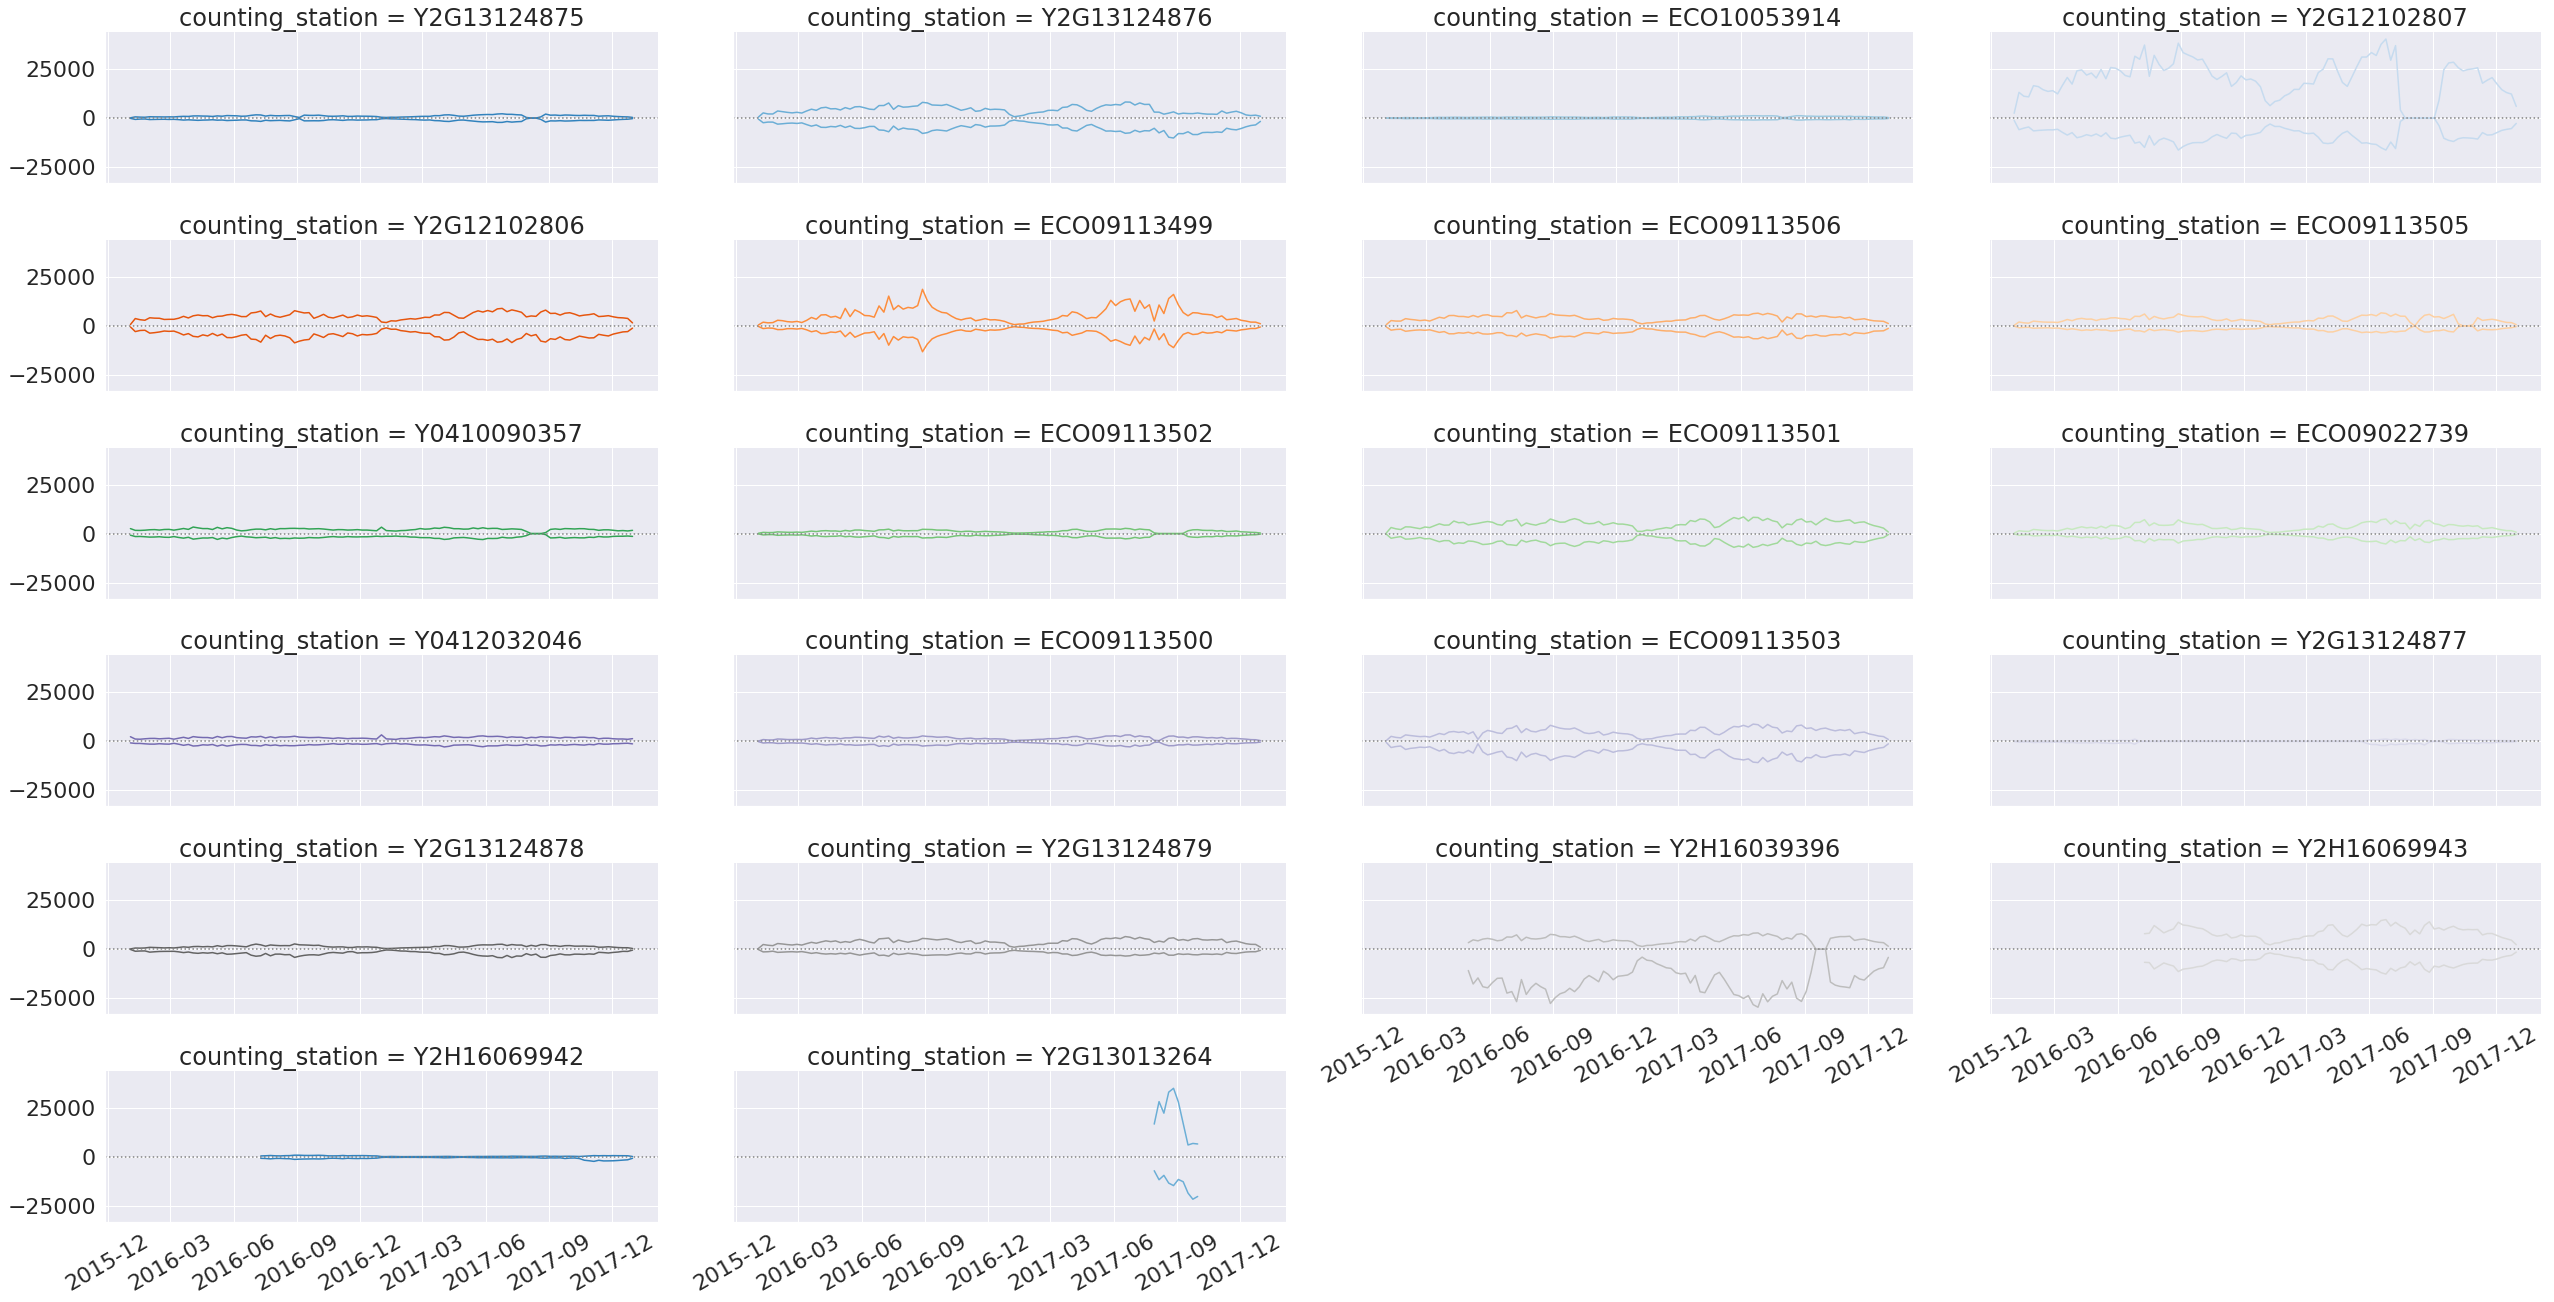

In [18]:
sns.set(font_scale=2)
grid = sns.FacetGrid(df_weekly, col="counting_station", hue="counting_station", palette="tab20c",
                     col_wrap=4, height=3, aspect=3)
grid.map(plt.plot, "datetime", "velo_in")
grid.map(plt.plot, "datetime", "velo_out")
grid.map(plt.axhline, y=0, ls=":", c=".5")
grid.set_xticklabels(rotation=30)

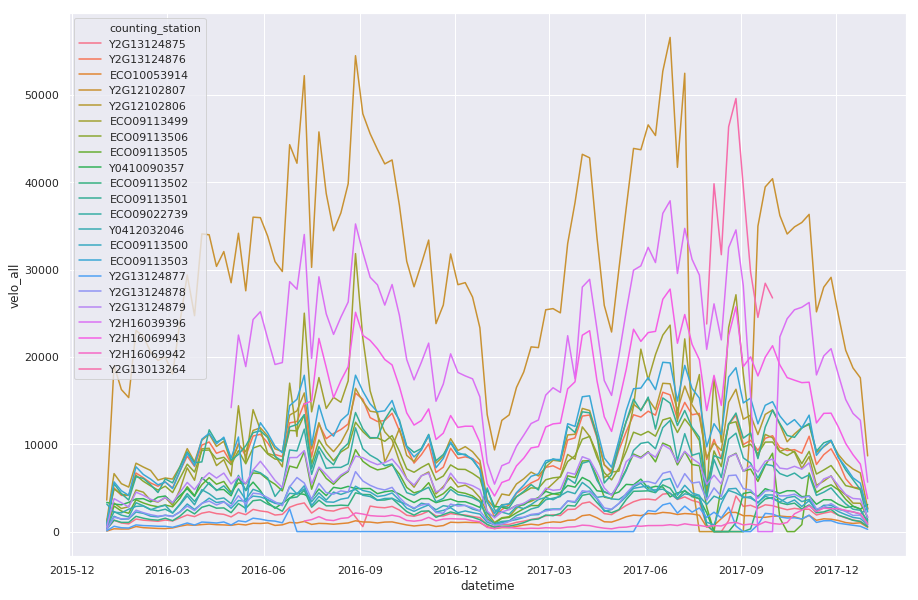

In [19]:
sns.set(rc={'figure.figsize':(15, 10)})
sns.lineplot(x="datetime", y="velo_all", hue="counting_station", data=df_weekly)